In [1]:
from math import pi as pi
from math import sqrt as sqrt
import BondGraphTools as bgt 

List = []
with open('bgt_test_opencor.cco') as f:
    for line in f:
        miniList = [elt.strip() for elt in line.split(',')]
        List.append(miniList)

vesselsNum = int(List[4][0]) # Number of the total vessels 
vesselsInfo=[]
for i in range(5,vesselsNum+5): # locations of the vessels' information
    vesselsInfo.append([float(x) for x in List[i][0].split()])

connectionInfo=[]
for i in range(12,len(List)): # locations of the connections' information
    connectionInfo.append([int(x) for x in List[i][0].split()])


In [2]:
vesselsInfo

[[0.0, 0.012, 0.00643],
 [1.0, 0.01233, 0.00503],
 [2.0, 0.007785, 0.00356],
 [3.0, 0.01574, 0.00275]]

In [3]:
connectionInfo

[[0, -1, 1], [1, 0, 2, 3], [2, 1], [3, 1]]

In [4]:
def RCILCal(vesselsNum,vesselsInfo): # gathers all the lengths of the vessels along with their IDs as keys
    from math import pi as pi        # and calculates R, C, and I for each vessel
    from math import sqrt as sqrt
    from math import exp as exp
    
    # Constant Parameters
    bloodViscosity=0.004
    E=0.6*1e6         # Young's modulus
    bloodDensity=1050
    a=0.2802      # vessel thickness
    b=-505.3      # vessel thickness
    c=0.1324      # vessel thickness
    d=-11.14      # vessel thickness
    
    vesselLength={}; RVal={}; CVal={}; IVal={}; RdVal={};
    for i in range(vesselsNum):  

        vesselID=int(vesselsInfo[i][0]) 
        RVal[vesselID]=[]
        CVal[vesselID]=[]
        IVal[vesselID]=[]
        RdVal[vesselID]=[]


        radius=vesselsInfo[i][2]

        vesselThickness=radius*(a*exp(b*radius)+c*exp(d*radius))

        vesselLength=vesselsInfo[i][1]

        RVal[vesselID]=(8*bloodViscosity*vesselLength)/(pi*pow(radius,4))

        CVal[vesselID]=(2*pi*pow(radius,3)*vesselLength)/(vesselThickness*E)

        IVal[vesselID]=(bloodDensity*vesselLength)/(pi*pow(radius,2))
        
        RdVal[vesselID]=0.01/CVal[vesselID]
        
        
    CVal[0]=CVal[0]/2

    return [RVal,CVal,IVal,RdVal]

In [5]:
[RVal,CVal,IVal,RdVal]=RCILCal(vesselsNum,vesselsInfo)

In [6]:
RdVal

{0: 258148446.78926486,
 1: 450731907.2349104,
 2: 1680410952.6539164,
 3: 1590237053.8151472}

In [7]:
IVal

{0: 97006.0289398635,
 1: 162879.53952145763,
 2: 205304.30084094903,
 3: 695630.7423417533}

In [8]:
RVal

{0: 71505.17271320346,
 1: 196196.49384528364,
 2: 493695.002052288,
 3: 2803328.926241462}

In [9]:
CVal

{0: 1.9368700692131864e-11,
 1: 2.218613734569327e-11,
 2: 5.950925268730689e-12,
 3: 6.2883706400935264e-12}

In [10]:
def bgComp(vesselsNum,RVal,CVal,IVal,RdVal):   
    import numpy as np
    import BondGraphTools as bgt
    
    R={}; C={}; I={}; Rd={}; one_junc_a={}; zero_junc={}; one_junc_b={}
    
    for v in range(vesselsNum):
        
        R[v]=[]
        C[v]=[]
        I[v]=[]
        Rd[v]=[]
        one_junc_a[v]=[]
        one_junc_b[v]=[]
        zero_junc[v]=[]
        
        R[v]=bgt.new("R", value=RVal[v], name='R_'+str(v))
        C[v]=bgt.new("C", value=CVal[v], name='C_'+str(v))
        I[v]=bgt.new("I", value=IVal[v], name='I_'+str(v))
        Rd[v]=bgt.new("R", value=RdVal[v], name='Rd_'+str(v))
        
        zero_junc[v]=bgt.new("0", name='zero_junc_'+str(v))
        one_junc_a[v]=bgt.new("1", name='one_junc_a_'+str(v))
        one_junc_b[v]=bgt.new("1", name='one_junc_b_'+str(v))
        
    return [R,C,I,Rd,one_junc_a,one_junc_b,zero_junc]

In [11]:
[R,C,I,Rd,one_junc_a,one_junc_b,zero_junc]=bgComp(vesselsNum,RVal,CVal,IVal,RdVal)

In [12]:
def CBR_sorting(C,R,I,zero_junc,one_junc_a,one_junc_b,Rd):
    # By the following appending, all the same components in each model are put together
    # So we need to separate them and gather all the components of each model in a row
    CBR=[]
    CBR.append([one_junc_a,one_junc_b,zero_junc,R,I,C,Rd]) 
    
    connectivity_bonds_row=[]
    for j in range(len(CBR[0][0])):
        for i in range(len(CBR[0])):
            connectivity_bonds_row.append(CBR[0][i][j])
            
    connectivity_bonds_column=connectivity_bonds_row
            
    return [connectivity_bonds_column,connectivity_bonds_row]        

In [13]:

[connectivity_bonds_column,connectivity_bonds_row] =CBR_sorting(C,R,I,zero_junc,one_junc_a,one_junc_b,Rd)

In [14]:
import BondGraphTools as bgt
model=bgt.new(name='bgt test')
for v in range(vesselsNum):
    bgt.add(model,R[v],C[v],I[v],one_junc_a[v],one_junc_b[v],zero_junc[v],Rd[v])

In [15]:
def CM_Creation(vesselsNum):
    import numpy as np
    from copy import copy, deepcopy
    
    #  connectivity matrix for one vessel
    connectivity_matrix_v=[[0,0,1,1,1,0,0],
                           [0,0,0,0,0,1,1],
                           [0,1,0,0,0,0,0],
                           [0,0,0,0,0,0,0],
                           [0,0,0,0,0,0,0],
                           [0,0,0,0,0,0,0],
                           [0,0,0,0,0,0,0]]
    
    CM={}
    
    # Creating a dictionary with empty lists for adding the connectivity matrices for each sub-system
    for n in range(vesselsNum):
        CM[str(n)]=deepcopy(connectivity_matrix_v)
    

    Length=0
    for n in range(vesselsNum):
        Length+=len(CM[str(n)])
    connectivity_matrix_0=np.zeros((Length,Length))  

    
    k=0
    for n in range(vesselsNum):
        for i in range(k,k+len(CM[str(n)])):
            for j in range(k,k+len(CM[str(n)])):
                connectivity_matrix_0[i][j]=deepcopy(CM[str(n)][i-k][j-k])
        k+=len(CM[str(n)])
        
    return connectivity_matrix_0
                           

In [16]:
connectivity_matrix_0=CM_Creation(vesselsNum)

In [17]:
def vesselConnect(connectionInfo,connectivity_bonds_row,connectivity_matrix_0):
    import numpy as np
    from copy import copy, deepcopy
    
    Name=[]
    for i in range(len(connectionInfo)):        
        
        if len(connectionInfo[i]) ==4:

            Name.append('zero_junc_'+str(connectionInfo[i][1]))
            Name.append('one_junc_a_'+str(connectionInfo[i][0]))
            
            Name.append('zero_junc_'+str(connectionInfo[i][0]))
            Name.append('one_junc_a_'+str(connectionInfo[i][2]))
            
            
            Name.append('zero_junc_'+str(connectionInfo[i][0]))
            Name.append('one_junc_a_'+str(connectionInfo[i][3]))
            
    Connection_between_models=[]
    for i in range(0,len(Name)): 
        for index in range(len(connectivity_bonds_row)):
                if Name[i] == connectivity_bonds_row[index].name:
                    Connection_between_models.append(index)
                    break

    connectivity_matrix=deepcopy(connectivity_matrix_0)
    for i in range(0,len(Connection_between_models),2):
        II=Connection_between_models[i]
        JJ=Connection_between_models[i+1]
        connectivity_matrix[II][JJ]=1        
    
    return connectivity_matrix
    

In [18]:
connectivity_matrix=vesselConnect(connectionInfo,connectivity_bonds_row,connectivity_matrix_0)

In [19]:
def BondsConnection(connectivity_matrix,connectivity_bonds_row,connectivity_bonds_column):
    import numpy as np
    import BondGraphTools as bgt
# Creating the bonds between the components based on the elements of the connectivity matrix
    Length=len(connectivity_matrix)
    bonds=[]  
    for i in range(Length):
        for j in range(Length):
            if connectivity_matrix[i][j]==1:
                bonds.append((connectivity_bonds_row[i],connectivity_bonds_column[j]))
            else:
                m=0
    
    
    # connecting the components for a bond graph representation of the system
    for head, tail in bonds:
        bgt.connect(head,tail)
    
    return bonds

In [20]:
bonds=BondsConnection(connectivity_matrix,connectivity_bonds_row,connectivity_bonds_column)

In [21]:
len(model.bonds)

27

In [22]:
def inputConnection(model,one_junc_a):
    import numpy as np
    import BondGraphTools as bgt

    Sf=bgt.new("Sf",name='Sf_in')
    C_00=bgt.new("C", value=CVal[0], name='C_00')  #CVal[0] was previously reduced to half
    zero_junc_00=bgt.new("0", name='zero_junc_00')
    
    bgt.add(model,Sf,C_00,zero_junc_00)
    
    bgt.connect(Sf,zero_junc_00)
    bgt.connect(zero_junc_00,C_00)
    bgt.connect(zero_junc_00,one_junc_a[0])
    

    return model

In [23]:
model=inputConnection(model,one_junc_a)

In [24]:
len(model.bonds)

30

In [25]:
def Get_Boundary(vesselsNum,bonds,model,zero_junc):
    import BondGraphTools as bgt

    count_zero_junc={}

    for m in range(0,vesselsNum):
        itr=0

        for i in range(0,len(bonds)):
            for j in range(0,2):
                
                if bonds[i][j].name=='zero_junc_'+str(m):
                    itr += 1
                    count_zero_junc[str(m)]=itr

                    
    Se=[]; Rt=[]; It=[]; one_junc_t=[];
    i=0
    for m in range(0,vesselsNum):
        if count_zero_junc[str(m)] ==2:
            R[m].set_param('r',RVal[m]/2)
            I[m].set_param('L',IVal[m]/2)
            
            Se.append(bgt.new("Se", value=0, name='Se_'+str(m)))    
            Rt.append(bgt.new("R", value=RVal[m]/2, name='Rt_'+str(m))) # R in terminal
            It.append(bgt.new("I", value=IVal[m]/2, name='It_'+str(m))) # I in terminal
            one_junc_t.append(bgt.new("1", name='one_junc_t'+str(m)))   # 1-junc in terminal
            
            bgt.add(model,Se[i],Rt[i],It[i],one_junc_t[i])
            
            bgt.connect(zero_junc[m],one_junc_t[i])
            bgt.connect(one_junc_t[i],Rt[i])
            bgt.connect(one_junc_t[i],It[i])
            bgt.connect(Se[i],one_junc_t[i])


            i+=1

                    
    return model

In [26]:
model=Get_Boundary(vesselsNum,bonds,model,zero_junc)

In [27]:
def combineDict(x0,vesselsNum):
    incKey = 0
    newDict = {}
    for m in range(vesselsNum):
        for val in x0:
            newDict['x_'+str(incKey)] = val
            incKey+=1
    return newDict

In [28]:
x0=[0]
    
x_0=combineDict(x0,len(model.state_vars))

In [29]:
model.state_vars

{'x_0': (C: C_0, 'q_0'),
 'x_1': (I: I_0, 'p_0'),
 'x_2': (C: C_1, 'q_0'),
 'x_3': (I: I_1, 'p_0'),
 'x_4': (C: C_2, 'q_0'),
 'x_5': (I: I_2, 'p_0'),
 'x_6': (C: C_3, 'q_0'),
 'x_7': (I: I_3, 'p_0'),
 'x_8': (C: C_00, 'q_0'),
 'x_9': (I: It_2, 'p_0'),
 'x_10': (I: It_3, 'p_0')}

In [ ]:
[x_0,model]=main('CircularDomain_200.cco','Kidney Vessels')

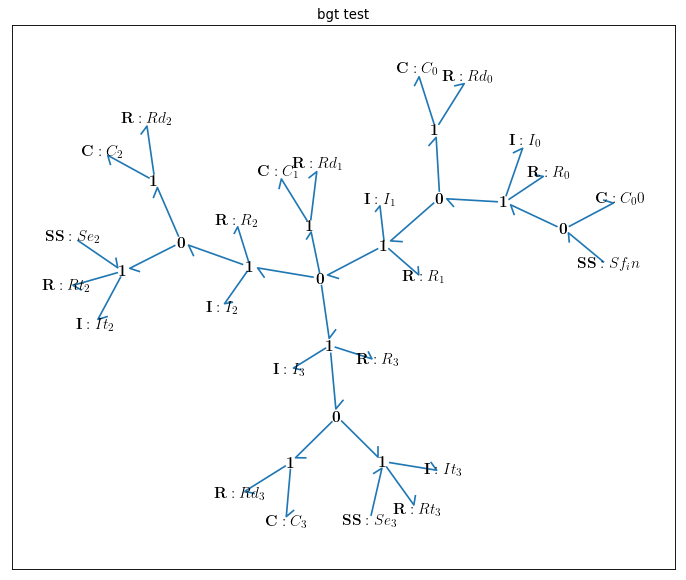

In [31]:
import BondGraphTools as bgt
bgt.draw(model)

In [32]:
import BondGraphTools as bgt
from math import sin as sin
from math import floor as floor
import time
start_time = time.time()
time_span=[0,1]
sinus= '0<t<0.3 ? 0.1*1e-6*sin(pi*(t-floor(t))/0.3) :0'
t, x = bgt.simulate(model, timespan=time_span, x0=x_0, dt=0.01, control_vars={'u_0':sinus})
elapsed_time_simulation = time.time() - start_time

In [33]:
elapsed_time_simulation

34.53644323348999

In [34]:
model.state_vars

{'x_0': (C: C_0, 'q_0'),
 'x_1': (I: I_0, 'p_0'),
 'x_2': (C: C_1, 'q_0'),
 'x_3': (I: I_1, 'p_0'),
 'x_4': (C: C_2, 'q_0'),
 'x_5': (I: I_2, 'p_0'),
 'x_6': (C: C_3, 'q_0'),
 'x_7': (I: I_3, 'p_0'),
 'x_8': (C: C_00, 'q_0'),
 'x_9': (I: It_2, 'p_0'),
 'x_10': (I: It_3, 'p_0')}

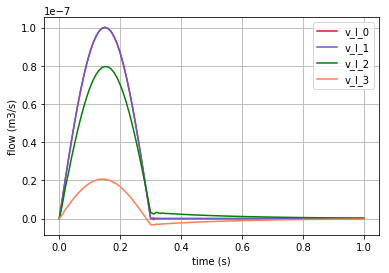

In [35]:
# For 5 vessels
v_I_0=x[:,1]/(IVal[0])
v_I_1=x[:,3]/(IVal[1])
v_I_2=x[:,5]/(IVal[2]/2)
v_I_3=x[:,7]/(IVal[3]/2)
# 
import matplotlib.pyplot as plt
for v, c, label in [(v_I_0,'crimson', 'v_I_0'),(v_I_1,'slateblue', 'v_I_1'),(v_I_2,'g', 'v_I_2'),(v_I_3,'coral', 'v_I_3')]:
    fig=plt.plot(t,v,c, label=label)
    plt.xlabel("time (s)")
    plt.ylabel("flow (m3/s)") 
    plt.legend(loc='upper right')
plt.grid()